In [1]:
using DrWatson
@quickactivate projectdir()

using CSV,DataFrames
using StatsBase
using StatsPlots
theme(:default, grid=false, tickdir=:out, label=:none)

In [2]:
ddir = datadir("exp_raw", "BBConsortia")

"/Users/bend/projects/Doran_etal_2022/data/exp_raw/BBConsortia"

In [3]:
smpmap = CSV.read(joinpath(ddir, "DFI_HMMF_1256_biobank-evnin_EW021622-5c6e08.tsv"), DataFrame; delim="\t");
df = CSV.read(joinpath(ddir, "removed_qcs_quant_results_20220301_PFBBr_EVIT1256_20220304.csv"), DataFrame);
df = leftjoin(smpmap, df, on=:HMMF_sampleid => :sampleid);

In [4]:
keepids = [
    "DFI.2.45",
    "DFI.1.234",
    "CON.062",
    # "blank",
]

3-element Vector{String}:
 "DFI.2.45"
 "DFI.1.234"
 "CON.062"

In [5]:
subset(df, :msk_id => ByRow(∈(["blank"]))) |> 
    df -> sort(df, [:msk_id, "taurocholic_acid__ug.ml"]) |>
    df -> select(df, 
        :msk_id,
        "taurocholic_acid__ug.ml" => :condition,
        :Acetate,
        :Butyrate, 
        :Propionate,
        :Succinate,
    ) |>
    df -> groupby(df, [:msk_id, :condition]) |>
    df -> combine(df, [:Acetate, :Butyrate,:Propionate, :Succinate] .=> mean)

Row,msk_id,condition,Acetate_mean,Butyrate_mean,Propionate_mean,Succinate_mean
,String15,Int64,Float64,Float64,Float64,Float64
1,blank,0,4.34333,0.14,0.14,0.833333
2,blank,5,4.29667,0.126667,0.143333,0.82


In [6]:
pltdf = subset(df, :msk_id => ByRow(∈(keepids))) |> 
    df -> sort(df, [:msk_id, "taurocholic_acid__ug.ml"]) |>
    df -> select(df, 
        :msk_id,
        "taurocholic_acid__ug.ml" => :condition,
        :Acetate,
        :Butyrate, 
        :Propionate,
        :Succinate,
    ) |>
    df -> transform(df,
        :Acetate => ByRow(x->log2(x/4.3)) => :Acetate_log2FC
    )

Row,msk_id,condition,Acetate,Butyrate,Propionate,Succinate,Acetate_log2FC
,String15,Int64,Float64?,Float64?,Float64?,Float64?,Float64
1,CON.062,0,23.54,0.11,0.11,0.79,2.45271
2,CON.062,0,24.1,0.12,0.11,0.84,2.48662
3,CON.062,0,30.43,0.16,0.12,1.03,2.82309
4,CON.062,5,23.44,0.13,0.12,0.83,2.44656
5,CON.062,5,22.47,0.11,0.13,0.78,2.38559
6,CON.062,5,24.69,0.12,0.1,0.9,2.52152
7,DFI.1.234,0,25.71,0.14,0.14,0.83,2.57992
8,DFI.1.234,0,24.34,0.12,0.1,0.7,2.50092
9,DFI.1.234,0,24.17,0.13,0.11,0.75,2.49081


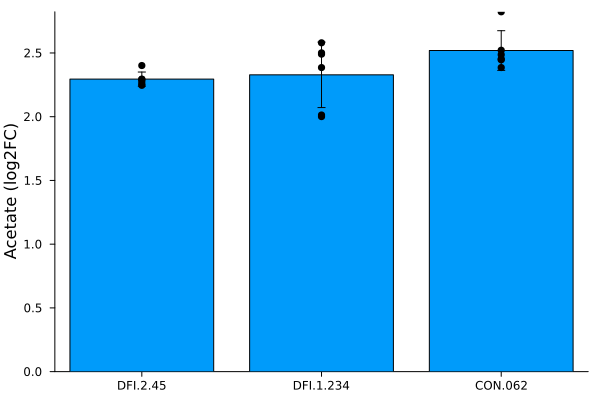

In [8]:
plot(ylabel="Acetate (log2FC)",)
# @df pltdf boxplot!(:msk_id, :Acetate_log2FC)
groupby(pltdf, :msk_id) |>
    df -> combine(df,
        :Acetate_log2FC => mean,
        :Acetate_log2FC => std,
    ) |>
    x->@df x bar!(:msk_id, :Acetate_log2FC_mean, 
        yerror=:Acetate_log2FC_std,
        # xticks=(1:3, :msk_id)
    )

# @df pltdf bar!(:msk_id, :Acetate_log2FC)
@df pltdf scatter!(:msk_id, :Acetate_log2FC, c=:black, widen=false)

In [10]:
pdir = plotsdir("consortiabackground") |> mkpath

"/Users/bend/projects/Doran_etal_2022/plots/consortiabackground"

In [11]:
savefig(joinpath(pdir, "barplot_acetate.pdf"))

"/Users/bend/projects/Doran_etal_2022/plots/consortiabackground/barplot_acetate.pdf"

In [24]:
pvals = Float64[]

Float64[]

In [25]:
x = pltdf.Acetate_log2FC[pltdf.msk_id .== "DFI.1.234"]
y = pltdf.Acetate_log2FC[pltdf.msk_id .== "DFI.2.45"];
using HypothesisTests
tst = MannWhitneyUTest(x,y)
push!(pvals, pvalue(tst))
tst

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.152652

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.4704

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             23.0
    rank sums:                            [44.0, 34.0]
    adjustment for ties:                  6.0
    normal approximation (μ, σ):          (5.0, 6.23407)


In [26]:
x = pltdf.Acetate_log2FC[pltdf.msk_id .== "DFI.1.234"]
y = pltdf.Acetate_log2FC[pltdf.msk_id .== "CON.062"];
tst = MannWhitneyUTest(x,y)
push!(pvals, pvalue(tst))
tst

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0314649

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5211

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             13.5
    rank sums:                            [34.5, 43.5]
    adjustment for ties:                  6.0
    normal approximation (μ, σ):          (-4.5, 6.23407)


In [27]:
x = pltdf.Acetate_log2FC[pltdf.msk_id .== "DFI.2.45"]
y = pltdf.Acetate_log2FC[pltdf.msk_id .== "CON.062"];
tst = MannWhitneyUTest(x,y)
push!(pvals, pvalue(tst))
tst

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.184117

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0081

Details:
    number of observations in each group: [6, 6]
    Mann-Whitney-U statistic:             1.0
    rank sums:                            [22.0, 56.0]
    adjustment for ties:                  6.0
    normal approximation (μ, σ):          (-17.0, 6.23407)


In [28]:
using MultipleTesting: adjust, Bonferroni

In [29]:
adjust(pvals, Bonferroni())

3-element Vector{Float64}:
 1.0
 1.0
 0.024381127893205352